In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import string
import numpy as np
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
# Load dataset from local path after download
data = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None)
data.columns = ['sentence', 'label']


In [6]:
# Separate reviews and labels
reviews = data['sentence'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
labels = data['label'].values
# Tokenize reviews
tokenized_reviews = reviews.str.split()
vocabulary = set(word for review in tokenized_reviews for word in review)
# Create word-to-integer dictionary
word2idx = {word: idx + 1 for idx, word in enumerate(vocabulary)}
# Encode reviews using the word2idx
encoded_reviews = [[word2idx[word] for word in review if word in word2idx] for review in tokenized_reviews]

# Padding encoded reviews for uniform length
max_len = max(len(review) for review in encoded_reviews)
encoded_reviews = [review + [0] * (max_len - len(review)) for review in encoded_reviews]
encoded_reviews = np.array(encoded_reviews)


In [8]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1])
        return self.sigmoid(out)

# Define model parameters
vocab_size = len(vocabulary) + 1
embed_dim = 64
hidden_dim = 128
output_dim = 1
n_layers = 3

# Instantiate model
model = SentimentRNN(vocab_size, embed_dim, hidden_dim, output_dim, n_layers)
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10


In [9]:
# Convert data to tensors
X_train, X_test, y_train, y_test = train_test_split(encoded_reviews, labels, test_size=0.2, random_state=42)
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    correct = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.round(output.squeeze())
        correct += torch.sum(predictions == labels).item()

    accuracy = correct / len(train_data)
    print(f'Epoch: {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch: 1, Loss: 17.3661, Accuracy: 0.4913
Epoch: 2, Loss: 17.3537, Accuracy: 0.5088
Epoch: 3, Loss: 17.3384, Accuracy: 0.4788
Epoch: 4, Loss: 17.3311, Accuracy: 0.5088
Epoch: 5, Loss: 17.3382, Accuracy: 0.4800
Epoch: 6, Loss: 17.3309, Accuracy: 0.5088
Epoch: 7, Loss: 17.3296, Accuracy: 0.5088
Epoch: 8, Loss: 17.3674, Accuracy: 0.5088
Epoch: 9, Loss: 17.3293, Accuracy: 0.5088
Epoch: 10, Loss: 17.3280, Accuracy: 0.5088


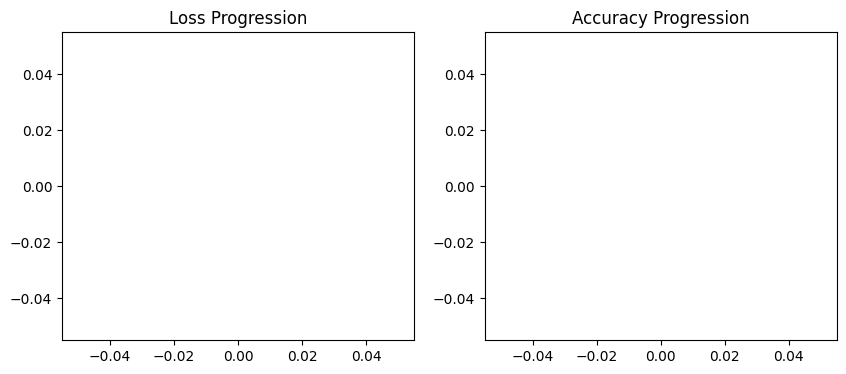

In [10]:
import matplotlib.pyplot as plt

losses = []
accuracies = []

# Append losses and accuracies after each epoch during training and then plot them
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title('Loss Progression')

plt.subplot(1,2,2)
plt.plot(accuracies)
plt.title('Accuracy Progression')
plt.show()


###Exercise 2


In [11]:
# Given text
sentence = """The larger Broncos will be available with 35-inch off-road tires and will be able
to drive through water nearly 3 feet, 10 inches deep. It has independent front suspension, unlike its main competitor, the Jeep Wrangler. Independent suspension, used
on almost all modern passenger vehicles, generally provides a smoother ride and better on -
road handling than a single solid axle. It still has a solid axle in the back though, like most
pickup trucks, a design suited to hard use. Like the Wrangler, both the two- and four-door
Bronco will have a removable roofs and doors. Buyers will be able to choose either a hard
roof that can be removed in sections, a cloth top, or both. Unlike the Wrangler, though, the
Bronco's doors will fit inside the vehicle after being removed. The Bronco will be available
with a choice of either a 10-speed automatic or seven-speed manual transmission. (The
manual transmission will have six gears for ordinary driving, plus a seventh for low speed
off-road driving.) It will be powered by either a 270- horsepower 2.3-liter turbocharged 4-
cylinder engine or a 310-horsepower 2.7-liter turbocharged V6. While all of the new Bronco
SUVs are designed for hard off-road use, the Bronco Sport isn't quite as hard-core in its
capabilities. It also has more convenience features than the more truck-like Bronco. While
it's based on engineering that's similar to car-like crossover SUVs, Ford says that it's still
intended for serious off-road use. Ford engineers boasted of the off-road testing the
prototypes have been put through, including driving through deep sand, up steep inclines ,
and crawling across boulder-strewn trails."""


### 1. Replace special characters with empty spaces. You can use regex or any other method


In [13]:
sentence = re.sub(r'[^\w\s]', ' ', sentence)

### 2. Remove multiple empty spaces and replace them with a single space


In [14]:
sentence = re.sub(r'\s+', ' ', sentence)

### 3. Remove any single character


In [15]:
sentence = ' '.join([word for word in sentence.split() if len(word) > 1])

### 4. Convert the text to all lowercase


In [16]:
sentence = sentence.lower()

### 5. Split the text into individual words


In [18]:
nltk.download('punkt')
words = word_tokenize(sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 6. Remove stopwords

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 7. Tokenize, stem, and lemmatize the text


In [22]:
import nltk
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

tokens = word_tokenize(' '.join(filtered_words))
stemmed_words = [ps.stem(word) for word in tokens]
lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]

[nltk_data] Downloading package wordnet to /root/nltk_data...


### 6. What is the overall sentiment and subjectivity of the text


In [24]:
from textblob import TextBlob

blob = TextBlob(sentence)
sentiment = blob.sentiment.polarity  # Returns sentiment: -1 (negative) to 1 (positive)
subjectivity = blob.sentiment.subjectivity  # Returns subjectivity: 0 (objective) to 1 (subjective)
